In [1]:
import pandas as pd
import numpy as np
from trustyai_experiments.pt_tabular import TabularFICO
import lime.lime_tabular
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
tab_model = TabularFICO()

In [3]:
tab_model.load('../saved_models/fico_tabular_basic')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [4]:
predict_proba = lambda x : tab_model.predict(x)[['Bad_probability', 'Good_probability']].values

In [5]:
data_df = pd.read_csv('../datasets/FICO/heloc_dataset_v1.csv')
train_df, test_df = train_test_split(data_df, test_size=0.2)
train_df, valid_df = train_test_split(train_df, test_size=0.1)

In [6]:
cat_indices = []
for col in tab_model.categorical_cols:
    cat_indices = cat_indices + [train_df.columns.get_loc(col)]

In [7]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_df.drop(['RiskPerformance'],axis=1).values, 
                                                   feature_names=tab_model.continuous_cols + tab_model.categorical_cols, 
                                                   categorical_features=cat_indices,
                                                   class_names=['Bad', 'Good'])

In [8]:
unl_test_df = test_df.drop(['RiskPerformance'],axis=1)

In [9]:
exp = explainer.explain_instance(unl_test_df.iloc[2], predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

Generating Predictions...:   0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
exp.as_list()


[('AverageMInFile > 95.00', 0.03490483995835965),
 ('MaxDelqEver <= 50.00', 0.03120074748233787),
 ('5.00 < NumRevolvingTradesWBalance <= 25.00', 0.02750989318418164),
 ('NumTrades60Ever2DerogPubRec > 1.00', -0.021258276618000147),
 ('ExternalRiskEstimate > 80.00', 0.02115255188232448),
 ('NumTradesOpeninLast12M=4', 0.018786677575075725),
 ('MaxDelq2PublicRecLast12M <= 0.00', 0.015706600915358204),
 ('MSinceMostRecentDelq > 14.00', 0.01394718923714444),
 ('NumTrades90Ever2DerogPubRec > 0.00', -0.012446282120014954),
 ('19.00 < NumSatisfactoryTrades <= 27.00', 0.008700349249207515)]

In [12]:
import trustyai

trustyai.init()

In [13]:
from trustyai.model import feature, output
from org.kie.kogito.explainability.model import PredictionInput, PredictionOutput, EncodingParams
from trustyai.model import simple_prediction
from trustyai.explainers import LimeExplainer
from trustyai.metrics import ExplainabilityMetrics
from org.kie.kogito.explainability.model import FeatureImportance

In [14]:
def predict(inputs):
    outputs = []
    values = np.zeros((len(inputs),len(inputs[0].features)))
    for idx in range(len(inputs)):
        values[idx] = np.array([_feature.value.as_obj() for _feature in inputs[idx].features])
    results = predict_proba(values)
    for result in results:
        false_prob, true_prob = result
        if false_prob > true_prob:
            _prediction = (False, false_prob)
        else:
            _prediction = (True, true_prob)
        _output = output(name="RiskPerformance", dtype="bool", value=_prediction[0], score=_prediction[1])
        po = PredictionOutput([_output])
        outputs.append(po)
    return outputs

In [15]:
from trustyai.model import Model

cb_model = Model(predict)

In [16]:
def make_feature(name, _value):
    if isinstance(_value, bool):
        return feature(name=name, dtype="bool", value=_value)
    else:
        return feature(name=name, dtype="number", value=_value)

In [17]:
sample = unl_test_df.iloc[0].to_dict()
sample

{'ExternalRiskEstimate': 85,
 'MSinceOldestTradeOpen': 226,
 'MSinceMostRecentTradeOpen': 2,
 'AverageMInFile': 84,
 'NumSatisfactoryTrades': 14,
 'NumTrades60Ever2DerogPubRec': 0,
 'NumTrades90Ever2DerogPubRec': 0,
 'PercentTradesNeverDelq': 100,
 'MSinceMostRecentDelq': -7,
 'MaxDelq2PublicRecLast12M': 7,
 'MaxDelqEver': 8,
 'NumTotalTrades': 27,
 'NumTradesOpeninLast12M': 1,
 'PercentInstallTrades': 13,
 'MSinceMostRecentInqexcl7days': 2,
 'NumInqLast6M': 1,
 'NumInqLast6Mexcl7days': 1,
 'NetFractionRevolvingBurden': 6,
 'NetFractionInstallBurden': -8,
 'NumRevolvingTradesWBalance': 6,
 'NumInstallTradesWBalance': -8,
 'NumBank2NatlTradesWHighUtilization': 0,
 'PercentTradesWBalance': 75}

In [40]:
features = [make_feature(k,v) for k,v in sample.items()]
len(features)

23

In [45]:
def eval_impact(explainer, model, test_df:pd.DataFrame, decision:str, k:int):
    mean_is = 0
    for idx in np.arange(len(test_df)):
        sample = test_df.iloc[idx].to_dict()
        features = [make_feature(k,v) for k,v in sample.items()]
        sample_input = PredictionInput(features)
        prediction = model.predictAsync([sample_input]).get()
        prediction_obj = simple_prediction(input_features=features, outputs=prediction[0].outputs)
        explanation = tlime_explainer.explain(prediction_obj, model)
        saliency = explanation._saliencies[decision]
        top_features_t = saliency.getTopFeatures(k)
        impact = ExplainabilityMetrics.impactScore(cb_model, prediction_obj, top_features_t)
        mean_is += impact
    return mean_is/len(test_df)

In [ ]:
eval_impact(tlime_explainer, cb_model, unl_test_df, 'RiskPerformance', 1)

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
sample_input = PredictionInput(features)
sample_input

<java object 'org.kie.kogito.explainability.model.PredictionInput'>

In [20]:
prediction = cb_model.predictAsync([sample_input]).get()
prediction[0].outputs[0].toString()

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

'Output{value=true, type=boolean, score=0.6982710361480713, name='RiskPerformance'}'

In [21]:
prediction_obj = simple_prediction(input_features=features, outputs=prediction[0].outputs)

In [22]:
tlime_explainer = LimeExplainer(samples=300, perturbations=1, seed=0, normalise_weights=False)

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

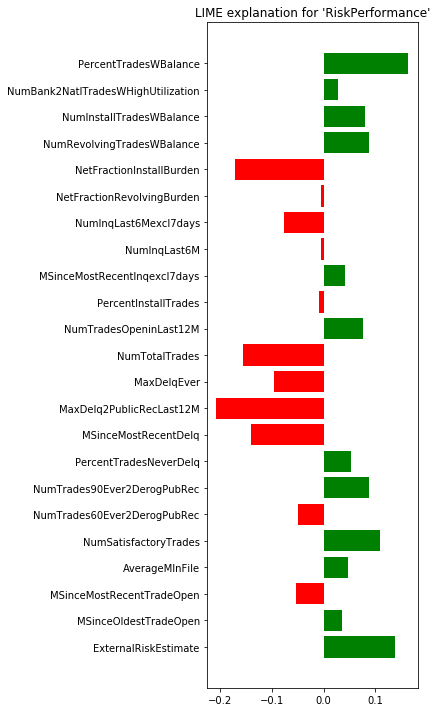

In [39]:
explanation = tlime_explainer.explain(prediction_obj, cb_model)
plt.figure(figsize=(6,10))
explanation.plot('RiskPerformance')

In [24]:
saliency = explanation._saliencies['RiskPerformance']
top_features_t = saliency.getTopFeatures(3)

In [25]:
top_features_t[0].getFeature().getName()

'MSinceMostRecentInqexcl7days'

In [26]:
ExplainabilityMetrics.impactScore(cb_model, prediction_obj, top_features_t)

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

0.0

In [27]:
def to_fis(exp, k):
    top_k = exp.as_list()[:k]
    fis = []
    for e in top_k:
        fn = e[0].split(' ')
        if len(fn) == 3:
            f = make_feature(fn[0], float(fn[2]))
        else:
            fn = e[0].split('=')
            f = make_feature(fn[0], float(fn[1]))
        imp = e[1]
        fi = FeatureImportance(f, imp)
        fis.append(fi)
    return fis

In [28]:
top_features_o = to_fis(exp, 3)

In [29]:
top_features_o[0].getFeature().getName()

'AverageMInFile'

In [42]:
ExplainabilityMetrics.impactScore(cb_model, prediction_obj, top_features_o)

Generating Predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

0.0